In [1]:
import sys
import os

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

sys.path.insert(0, os.path.abspath('..'))

from src.utils.load_cfg import ConfigLoader
from src.factories import ModelFactory
from src.factories import DatasetFactory
from src.utils.misc import MiscUtils
from src.models.pytorch_ssim.ssim import SSIM

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid', {'axes.grid': False})

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_cfg = '../configs/dataset_cfgs/epickitchens_short.yaml'
train_cfg = '../configs/train_cfgs/train_san_freeze_short.yaml'

In [2]:
# Deprocess data for visualization
def deprocess_rgb(rgb, num_segments):
    rgb = rgb.cpu().numpy()
    assert rgb.shape[0] == 1
    _, _, h, w = rgb.shape
    rgb = rgb.reshape([num_segments, 3, h, w]).transpose(0, 2, 3, 1)
    rgb *= 1  # std
    rgb += np.array([104, 117, 128])  # mean
    rgb = rgb.astype(np.uint8)
    return rgb


def deprocess_flow(flow, num_segments, new_length):
    flow = flow.cpu().numpy()
    assert flow.shape[0] == 1
    _, _, h, w = flow.shape
    flow = flow.reshape([num_segments, new_length, 2, h, w])
    flow *= 1  # std
    flow += 128  # mean
    flow = flow.astype(np.uint8)
    flow_x = flow[:, :, 0, :, :]
    flow_y = flow[:, :, 1, :, :]
    return flow_x, flow_y


def deprocess_spec(spec, num_segments):
    spec = spec.cpu().numpy()
    assert spec.shape[0] == 1
    _, _, h, w = spec.shape
    spec = spec.reshape([num_segments, h, w])
    return spec


def display_input(sample, num_segments):
    # Deprocess inputs
    rgb = deprocess_rgb(sample['RGB'], num_segments)
    spec = deprocess_spec(sample['Spec'], num_segments)

    # Display input RGB
    fig, axes = plt.subplots(1, num_segments, figsize=(3*num_segments, 5))
    fig.suptitle('='*30+'\n  RGB\n'+'='*30, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_segments):
        axes[i].imshow(cv2.cvtColor(rgb[i], cv2.COLOR_BGR2RGB))
        axes[i].axis('off')

    # Display input Spec
    fig, axes = plt.subplots(1, num_segments, figsize=(3*num_segments, 5))
    fig.suptitle('='*30+'\n  Spec\n'+'='*30, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_segments):
        axes[i].imshow(spec[i], cmap='viridis')
        axes[i].axis('off')

In [12]:
def run_experiment(model_cfg, weight, sample_id):
    # Load configurations
    model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)
    dataset_name, dataset_params = ConfigLoader.load_dataset_cfg(dataset_cfg)
    train_params = ConfigLoader.load_train_cfg(train_cfg)

    # Build model
    model_factory = ModelFactory()
    model = model_factory.generate(model_name, device=device, model_factory=model_factory, **model_params)
    model.load_model(weight)
    model = model.to(device)

    train_augmentation = MiscUtils.get_train_augmentation(
        ['RGB', 'Flow', 'Spec'], {'RGB': 224, 'Flow': 224, 'Spec': 224}
    )
    train_transform, val_transform = MiscUtils.get_train_val_transforms(
        modality=['RGB', 'Flow', 'Spec'],
        input_mean={'RGB': [104, 117, 128], 'Flow': [128]},
        input_std={'RGB': [1], 'Flow': [1], 'Spec': [1]},
        scale_size={'RGB': 256, 'Flow': 256, 'Spec': 256},
        crop_size={'RGB': 224, 'Flow': 224, 'Spec': 224},
        train_augmentation=train_augmentation,
    )

    # Data loader
    dataset_params.update({
        'modality': ['RGB', 'Flow', 'Spec'],
        'num_segments': model.num_segments,
        'new_length': {'RGB': 1, 'Flow': 1, 'Spec': 1},
    })
    dataset_factory = DatasetFactory()
    val_dataset = dataset_factory.generate(dataset_name, mode='val', transform=val_transform, **dataset_params)
    
    loader_params = {
        'batch_size': train_params['batch_size'],
        'num_workers': train_params['num_workers'],
        'pin_memory': True,
    }
    val_loader = DataLoader(val_dataset, shuffle=False, **loader_params)

    # Get a sample
    for i, (sample, target) in enumerate(val_loader):
        sample = {k: v.to(device) for k, v in sample.items()}
        target = {k: v.to(device) for k, v in target.items()}

        if i == sample_id:
            break

    # Forward
    model.eval()
    output = model(sample)

    # Get attention and flow
    attn = model._attn[0]
    flow = sample['Flow'][0]
    flow = flow.reshape([model.num_segments, dataset_params['new_length']['Flow'], 2, flow.shape[-2], flow.shape[-1]])
    flow_x = flow[:, :, 0, :, :].squeeze(dim=1)
    flow_y = flow[:, :, 1, :, :].squeeze(dim=1)
    new_size = attn.shape[-1]
    scaling = flow.shape[-1] / new_size

    params = {'size': new_size, 'mode': 'bilinear', 'align_corners': False}
    flow_x = F.interpolate(flow_x.unsqueeze(dim=1), **params) / scaling
    flow_y = F.interpolate(flow_y.unsqueeze(dim=1), **params) / scaling
    
    # Warp
    propag = torch.zeros(attn.shape).to(device)

    for i in range(new_size):
        for j in range(new_size):
            off_x, off_y = flow_x[..., i, j].round().squeeze(), flow_y[..., i, j].round().squeeze()
            u = i+off_y
            v = j+off_x
            for t in range(model.num_segments):
                if (0 <= u[t] <= new_size-1) and (0 <= v[t] <= new_size-1):
                    propag[t, :, int(u[t]), int(v[t])] += attn[t, :, i, j]

    # Visualization
    rgb = deprocess_rgb(sample['RGB'], model.num_segments)
    X, Y = np.meshgrid(np.arange(new_size), np.arange(new_size))
    fig, axes = plt.subplots(4, model.num_segments, figsize=(3*model.num_segments, 12))
    v_min, v_max = min(attn.mean(dim=1).min().item(), 0), attn.mean(dim=1).max().item()
    for t in range(model.num_segments):
        axes[0, t].imshow(attn[t].mean(dim=0).cpu().detach().numpy(), vmin=v_min, vmax=v_max)
        axes[1, t].imshow(propag[t].mean(dim=0).cpu().detach().numpy(), vmin=v_min, vmax=v_max)
        axes[2, t].quiver(X, Y, flow_x[t, 0].cpu().detach(), -flow_y[t, 0].cpu().detach())
        axes[2, t].invert_yaxis()
        axes[3, t].imshow(cv2.cvtColor(rgb[t], cv2.COLOR_BGR2RGB))

    axes[0, 0].set_ylabel('attention')
    axes[1, 0].set_ylabel('propagation')
    axes[2, 0].set_ylabel('flow')
    axes[3, 0].set_ylabel('rgb')

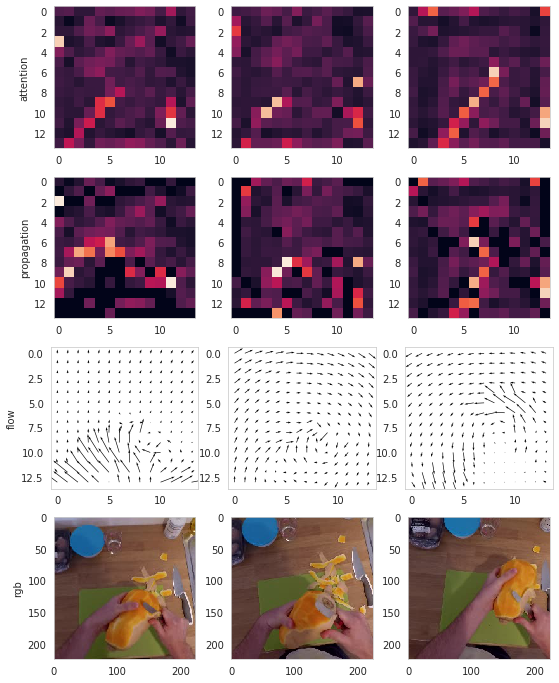

In [13]:
model_cfg = '../configs/model_cfgs/pipeline2_rgbspec_san19pairfreeze_actreggru_halluconvlstm.yaml'
weight = '../saved_models/san19freeze_halluconvlstm_actreggru/dim32_layer1_nsegment3/epoch_00049.model'
sample_id = 64

run_experiment(model_cfg, weight, sample_id)